In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DA2/

Mounted at /content/drive
/content/drive/MyDrive/DA2


In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
dsf=pd.read_csv("ETH-USD.csv")
print('Data size:', df.shape)
dsf.head(5)

Data size: (1777, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Change
0,8/8/2015,2.793760,2.798810,0.714725,0.753325,0.753325,674188,-0.728249
1,8/9/2015,0.706136,0.879810,0.629191,0.701897,0.701897,532170,-0.068268
2,8/10/2015,0.713989,0.729854,0.636546,0.708448,0.708448,405283,0.009333
3,8/11/2015,0.708087,1.131410,0.663235,1.067860,1.067860,1463100,0.507323
4,8/12/2015,1.058750,1.289940,0.883608,1.217440,1.217440,2150620,0.140075


In [ ]:
df = dsf.iloc[500:,:]
(num_row, num_column) = df.shape
print('Number of rows: ',num_row)
num_test = 180
num_train = num_row - num_test 


Number of rows:  1777


In [ ]:
training_set = df.iloc[:+num_train, 4:5].values
test_set = df.iloc[num_train:, 4:5].values
# print(training_set)
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# print(training_set_scaled)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, num_train):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(y_train.shape)

(1537, 60)
(1537,)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(sc)

(1677, 60, 1)
(1677,)
MinMaxScaler()


In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
# Fitting the RNN to the Training set if the data has never been trained 
# import os.path
# from os import path
# path_name = 'Ethereum_PricePredict_1737.h5'
# if path.exists(path_name):
#   print('Data had been trained, loading weights')
#   model.load_weights(path_name)
# else:
#   print('Start training data')
model.fit(X_train, y_train, epochs = 2, batch_size = 32)
  # model.save(path_name)

Epoch 1/2
49/49 [==============================] - 3s 60ms/step - loss: 5.1089e-04
Epoch 2/2
49/49 [==============================] - 3s 61ms/step - loss: 4.4709e-04


(179, 60, 1)


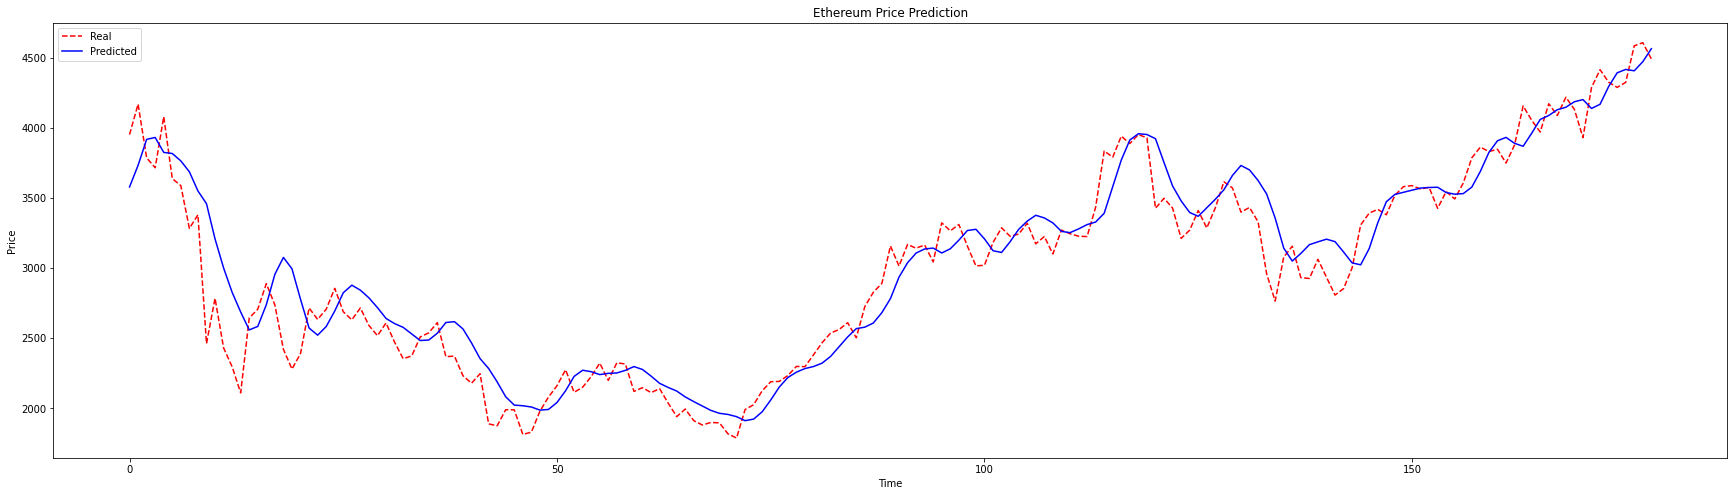

In [ ]:
# Getting the predicted 
dataset_train = df.iloc[:num_train, 4:5]
dataset_test = df.iloc[num_train+1:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 60 + num_test-1):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_stock_price = model.predict(X_test)
#print(predicted_stock_price)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#print('after inverse transform:', predicted_stock_price)
# Visualising the results
plt.figure(figsize=(30,8))
plt.plot(dataset_test.values, 'r--', label = 'Real')
plt.plot(predicted_stock_price, 'b', label = 'Predicted')
plt.xticks(np.arange(0,num_test,50))
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
#plt.figure(figsize=(1,1))
#plt.rcParams['figure.figsize'] = [10, 5]
plt.show()


In [ ]:
MAPE = np.abs(predicted_stock_price - dataset_test.values)
RMSE = np.multiply(MAPE,MAPE)
RMSE = math.sqrt(np.mean(RMSE))/np.mean(dataset_test.values)
MAE = np.mean(MAPE)/np.mean(dataset_test.values)
MAPE = np.divide(MAPE,dataset_test.values)
MAPE = np.mean(MAPE)
print('MAPE = ',MAPE)
print('MAE = ', MAE*100, '%')
print('RMSE = ',RMSE*100, '%')


MAPE =  0.05964939756899869
MAE =  5.5202446004445065 %
RMSE =  7.438238418358399 %
